In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
import pandas as pd
from ruamel.yaml import YAML as ym
import datetime
import copy
import re
import scipy.fft
import pickle

# Use this for interactive graphs - nice for exploring
#%matplotlib widget

%matplotlib inline

import mplcursors

sys.path.append("..")
from processing import *
sys.path.append("../../preprocessing")
from generate_chirp import generate_chirp

# Widgets are only needed if you want to use the interactive plot at the end
# Installation instructions: https://ipywidgets.readthedocs.io/en/latest/user_install.html
import ipywidgets as widgets

In [ ]:
# 50 m loopback, attenuators on TX side
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_102532" # 30 dB att -- peak 40 floor -10
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123354" # 40 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123254" # 50 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_115443" # 60 dB att -- peak 10 floor -30
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123054" # 70 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122940" # 80 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_120142" # 90 dB att --
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122804" # 100 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122602" # 110 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122022" # 120 dB att
#prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122254" # 130 dB att

#prefix = "../../drone/radar_data/20230511-bench-loopbacksums/20230511_123724" # 90 dB att, 40 MHz BW
#prefix = "../../drone/radar_data/20230511-bench-loopbacksums/20230511_123841" # 120 dB att, 40 MHz BW


#prefix = "../../drone/radar_data/20230511-bench-loopbacksums/20230511_125023" # 90 dB att, 40 MHz BW, blackman tx
#prefix = "../../drone/radar_data/20230511-bench-loopbacksums/20230511_124759" # 120 dB att, 40 MHz BW, blackman tx

In [ ]:
# 5-11 Bench testing

# loopback_tests = { # 1000 pulses
#     30: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_102532",
#     40: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123354",
#     50: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123254",
#     60: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_115443",
#     70: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123054",
#     80: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122940",
#     90: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_120142",
#     100: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122804",
#     110: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122602",
#     120: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122022",
#     130: "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_122254"
# }

# loopback_tests = {
#     90: "../../../drone/radar_data/20230516-bench-sidelobes/20230516_093854"
# }

# loopback_tests = {
#     30: "../../../drone/radar_data/20230516-bench-sidelobes/20230516_104415", # 100,000 pulses, 30 dB att, 10 us pulse, 30 us recording (30 dB meas #1)
#     45: "../../../drone/radar_data/20230516-bench-sidelobes/20230516_113631", # 100,000 pulses, 45 dB att, 10 us pulse, 30 us recording (45 dB meas #1)
#     60: "../../../drone/radar_data/20230516-bench-sidelobes/20230516_121650" # (60 dB meas #1)
# }

In [3]:
loopback_tests = {
    # 130: "../../data/20230616_090221", 
    # 140: "../../data/20230616_092046", 
    # 150: "../../data/20230616_093356",
    # 160: "../../data/20230616_110144"
    # 110: "../../data/20230616_154046", # actually 120 dB
    # #120: "../../data/20230623_013905" # actually 120 dB
    # 120: "../../data/20230626_095802", # actually 120 dB
    # 130: "../../data/20230626_120534", # actually 90 dB
    # 100: "../../data/20230626_143830", # actually 90 dB
    # 90: "../../data/20230706_101607"
    90: "../../data/20230706_122351" 
}

In [4]:
# Thomas's system at 56 MHz sample rate - zero_sample_idx = 159
# anna's is 36 for 20 MHz sample rate
# 45 for 5 MHz sample rate? 
zero_sample_idx = 45

sig_speed = scipy.constants.speed_of_light * 2/3 # COAX
reflector_distance_expected = 50 # m
#noise_start_m, noise_end_m = 50, 400
noise_start_m, noise_end_m = 2000, 4500

n_stack = 10000

In [ ]:
plot_data = {
    'atten': [],
    'signal_mean': [],
    'noise_mean': [],
    'noise_std': []
}

fig2, ax2 = plt.subplots(figsize=(10,6), facecolor='white')

for atten_db in loopback_tests.keys():
    prefix = loopback_tests[atten_db]
    
    slow_time, fs, radar_data = load_radar_data(prefix, error_behavior='remove')
    print('radar_data shape: ', radar_data.shape)
    #_, chirp = generate_chirp(load_config(prefix, modifications={'GENERATE': {'window':'blackman'}}))
    _, chirp = generate_chirp(load_config(prefix))
    
    stacked = stack(radar_data, n_stack)
    fast_time, pulse_compressed = pulse_compress(stacked, chirp, fs, zero_sample_idx=zero_sample_idx)
    num_pulses = pulse_compressed.shape[1]

    dist_to_reflector = fast_time * sig_speed/2

    ret_power = 20*np.log10(np.abs(pulse_compressed))

    fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
    ax.plot(dist_to_reflector, ret_power[:,0])
    ax.grid()
    ax.set_xlabel("Distance to reflection")
    ax.set_ylabel("Return power [dB]")
    ax.text(0, 1.05, prefix.split("/")[-1] + "\n" + f"n_stack = {n_stack}, attenuation = {atten_db} dB", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    ax2.plot(ret_power[:,0])
    ax2.grid()
    ax2.set_xlabel("Samples")
    ax2.set_ylabel("Return power [dB]")
    
    # Signal
    expected_peak_idx = np.argmin(np.abs(dist_to_reflector - reflector_distance_expected))
    print('expected peak index: ', expected_peak_idx)
    search_start_idx = expected_peak_idx - 2
    sig_peak_pwr = np.amax(ret_power[search_start_idx:search_start_idx+5,:], axis=0)
    sig_peak_idx = np.argmax(ret_power[search_start_idx:search_start_idx+5,:], axis=0) + search_start_idx
    
    ax.scatter([dist_to_reflector[sig_peak_idx[0]]], sig_peak_pwr[0], c='red', label="Detected signal peak")

    # Noise
    noise_start_idx = np.argmin(np.abs(dist_to_reflector - noise_start_m))
    noise_end_idx = np.argmin(np.abs(dist_to_reflector - noise_end_m))
    noise_region = np.abs(pulse_compressed[noise_start_idx:noise_end_idx,:])
    noise_mean, noise_std = np.mean(noise_region, axis=0), np.std(noise_region, axis=0)
    noise_mean_db = 20*np.log10(noise_mean)
    noise_mean_m1std = 20*np.log10(noise_mean - noise_std)
    noise_mean_p1std = 20*np.log10(noise_mean + noise_std)

    ax.fill_between(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_m1std[0] * np.ones_like(noise_region[:,0]), noise_mean_p1std[0] * np.ones_like(noise_region[:,0]),
                   alpha=0.2, color='green')
    ax.plot(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_db[0] * np.ones_like(noise_region[:,0]), c='green', linestyle="--")
    #ax.set_xlim(0, 250)
    # # Autocorrelation
#     _, chirp_unmodified = generate_chirp(load_config(prefix))
#     tx_sig_autocorr = sp.correlate(chirp_unmodified, chirp, mode='same', method='auto')
#     tx_sig_autocorr_db = 20*np.log10(np.abs(tx_sig_autocorr))
#     tx_sig_autocorr_db = tx_sig_autocorr_db - np.max(tx_sig_autocorr_db) + ret_power[np.argmin(np.abs(dist_to_reflector))]

#     distance_to_reflector_autocorr = np.linspace(0, len(tx_sig_autocorr)/fs, len(tx_sig_autocorr)) * sig_speed / 2
#     distance_to_reflector_autocorr = distance_to_reflector_autocorr - distance_to_reflector_autocorr[len(tx_sig_autocorr)//2]
    
#     ax.plot(distance_to_reflector_autocorr, tx_sig_autocorr_db, linestyle="--")
    
    # Limits and saving
    #ax.set_ylim(-130, -100)
    
    #fig.savefig(f'plots/loopback_snr_{atten_db}db_{prefix.split("/")[-1]}.png')

    plot_data['atten'].append(atten_db)
    plot_data['signal_mean'].append(np.abs(np.mean(pulse_compressed[np.array(sig_peak_idx), np.arange(0, num_pulses)])))
    plot_data['noise_mean'].append(np.mean(noise_mean))
    plot_data['noise_std'].append(np.mean(noise_std))


In [ ]:
fig, ax1 = plt.subplots(figsize=(12,10), facecolor='white')
ax2 = ax1.twinx()
ax1.scatter(plot_data['atten'], 20*np.log10(plot_data['signal_mean']), label="Signal Mean [dB]", c='tab:blue')
ax1.scatter(plot_data['atten'], 20*np.log10(plot_data['noise_mean']), label="Noise Mean [dB]", c='tab:orange')
#ax2.scatter(plot_data['atten'], 20*np.log10(np.array(plot_data['signal_mean']) / np.array(plot_data['noise_std'])), c='green')
ax2.scatter(plot_data['atten'], 20*np.log10(plot_data['noise_std']), label="Noise StDev [dB]", c='tab:green')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
ax1.grid()
#ax1.set_aspect('equal')
ax1.set_ylim(-140,-100)
#ax2.set_ylim(-140,-100)
ax1.set_title(f"n_stack = {n_stack}")

color = 'tab:green'
ax2.set_ylabel('Noise Standard Deviation', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(color=color, alpha=0.1)
ax1.set_xlabel('Attenuation [dB]')

In [ ]:
# Effect of stacking for one set of data

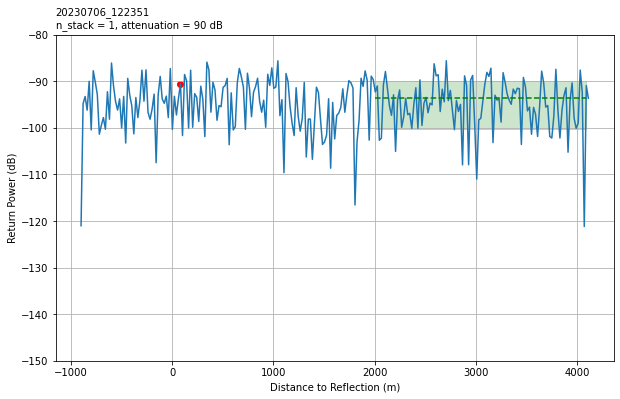

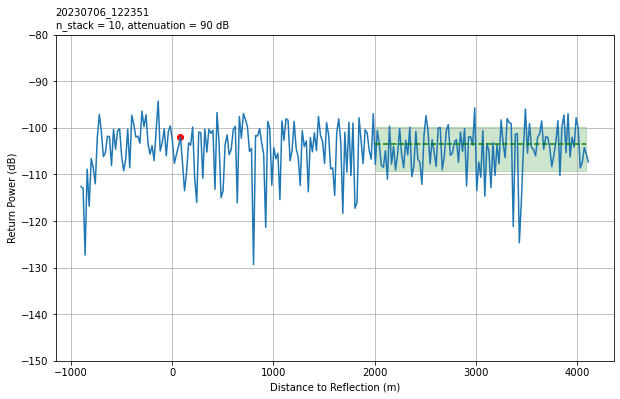

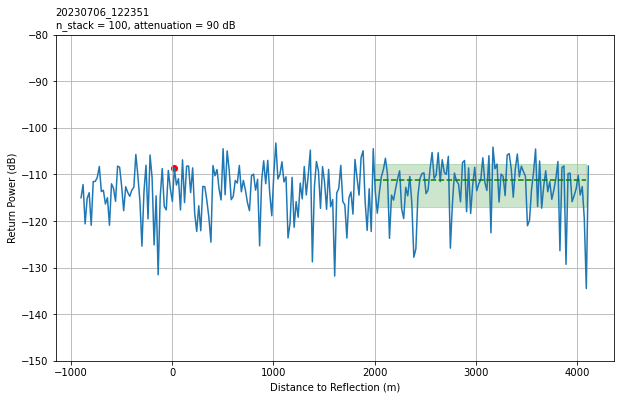

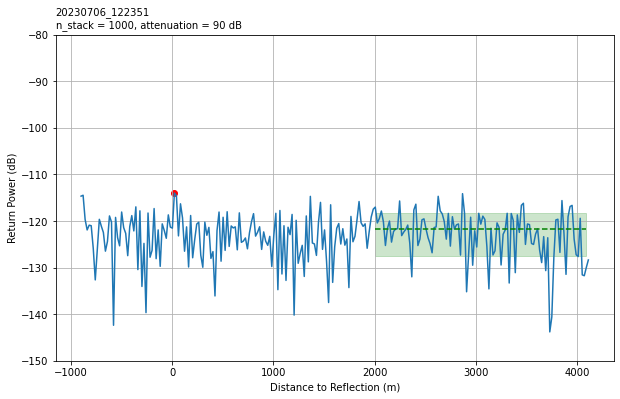

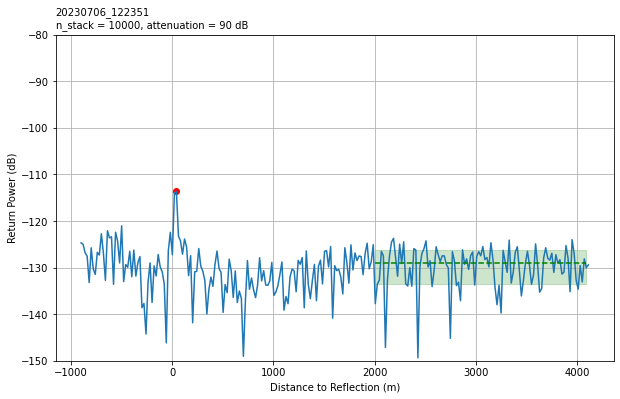

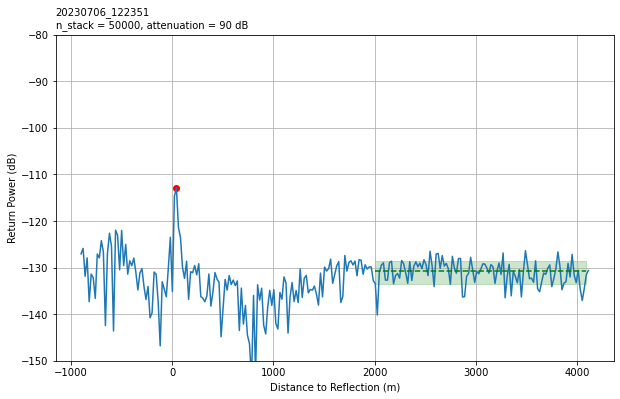

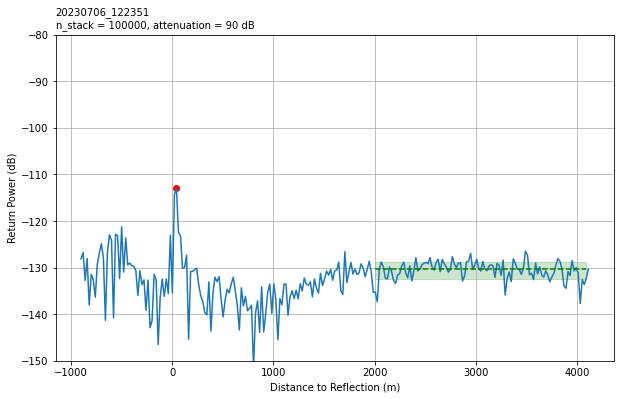

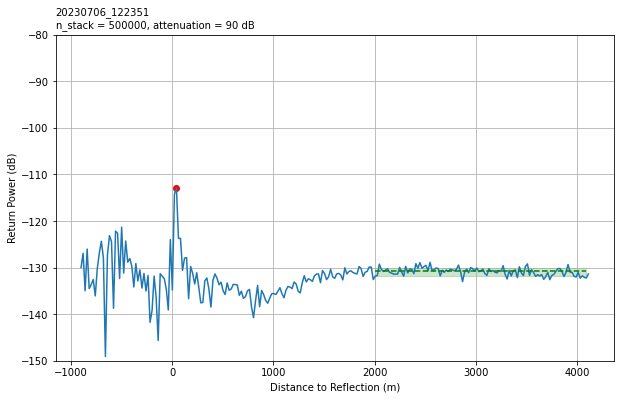

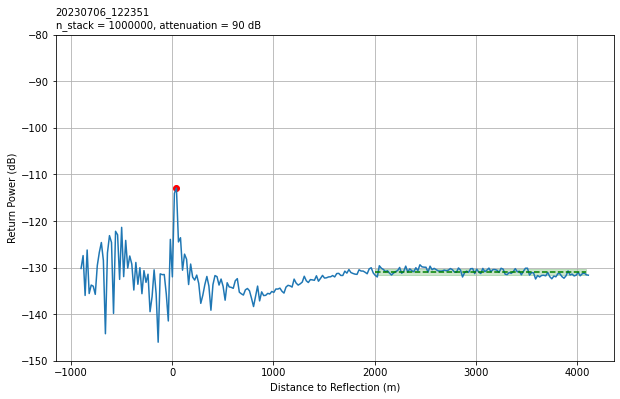

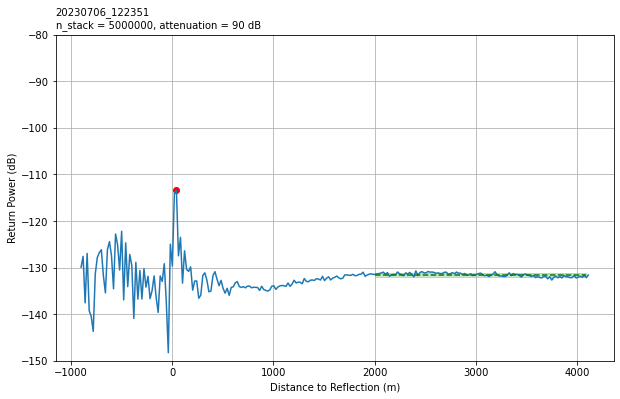

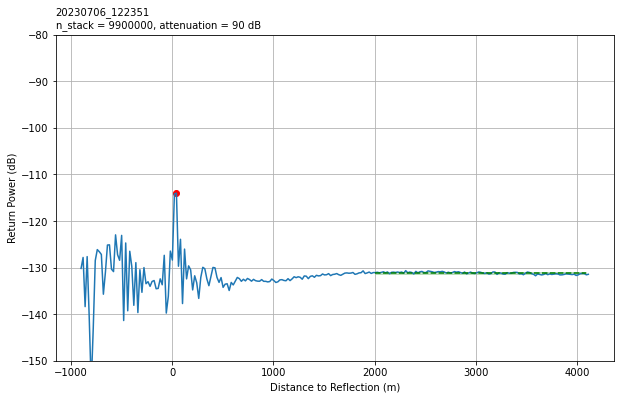

In [15]:
atten_db = 90
prefix = loopback_tests[atten_db]

plot_data_stack = {
    'n_stack': [],
    'signal_mean': [],
    'noise_mean': [],
    'noise_std': []
}

slow_time, fs, radar_data = load_radar_data(prefix, error_behavior='remove')
#_, chirp = generate_chirp(load_config(prefix, modifications={'GENERATE': {'window':'blackman'}}))
_, chirp = generate_chirp(load_config(prefix))

for idx, n_stack in enumerate([1, 10, 100, 1000, 10000, 50000, 100000, 500000, 1000000, 5000000, 9900000]):

    stacked = stack(radar_data, n_stack)
    fast_time, pulse_compressed = pulse_compress(stacked, chirp, fs, zero_sample_idx=zero_sample_idx)
    num_pulses = pulse_compressed.shape[1]

    dist_to_reflector = fast_time * sig_speed/2

    ret_power = 20*np.log10(np.abs(pulse_compressed))

    fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
    ax.plot(dist_to_reflector, ret_power[:,0])
    ax.grid()
    ax.set_xlabel("Distance to Reflection (m)")
    ax.set_ylabel("Return Power (dB)")
    ax.text(0, 1.05, prefix.split("/")[-1] + "\n" + f"n_stack = {n_stack}, attenuation = {atten_db} dB", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

    # Signal
    expected_peak_idx = np.argmin(np.abs(dist_to_reflector - reflector_distance_expected))
    search_start_idx = expected_peak_idx - 2
    sig_peak_pwr = np.amax(ret_power[search_start_idx:search_start_idx+5,:], axis=0)
    sig_peak_idx = np.argmax(ret_power[search_start_idx:search_start_idx+5,:], axis=0) + search_start_idx
    
    ax.scatter([dist_to_reflector[sig_peak_idx[0]]], sig_peak_pwr[0], c='red', label="Detected signal peak")

    # Noise
    noise_start_idx = np.argmin(np.abs(dist_to_reflector - noise_start_m))
    noise_end_idx = np.argmin(np.abs(dist_to_reflector - noise_end_m))
    noise_region = np.abs(pulse_compressed[noise_start_idx:noise_end_idx,:])
    noise_mean, noise_std = np.mean(noise_region, axis=0), np.std(noise_region, axis=0)
    noise_mean_db = 20*np.log10(noise_mean)
    noise_mean_m1std = 20*np.log10(noise_mean - noise_std)
    noise_mean_p1std = 20*np.log10(noise_mean + noise_std)

    ax.fill_between(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_m1std[0] * np.ones_like(noise_region[:,0]), noise_mean_p1std[0] * np.ones_like(noise_region[:,0]),
                   alpha=0.2, color='green')
    ax.plot(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_db[0] * np.ones_like(noise_region[:,0]), c='green', linestyle="--")
    
    ax.set_ylim(-150, -80)
    fig.savefig(f"plots/nstack{idx:02d}.png", dpi=300)
    
    plot_data_stack['n_stack'].append(n_stack)
    plot_data_stack['signal_mean'].append(np.abs(np.mean(pulse_compressed[np.array(sig_peak_idx), np.arange(0, num_pulses)])))
    plot_data_stack['noise_mean'].append(np.mean(noise_mean))
    plot_data_stack['noise_std'].append(np.mean(noise_std))

11


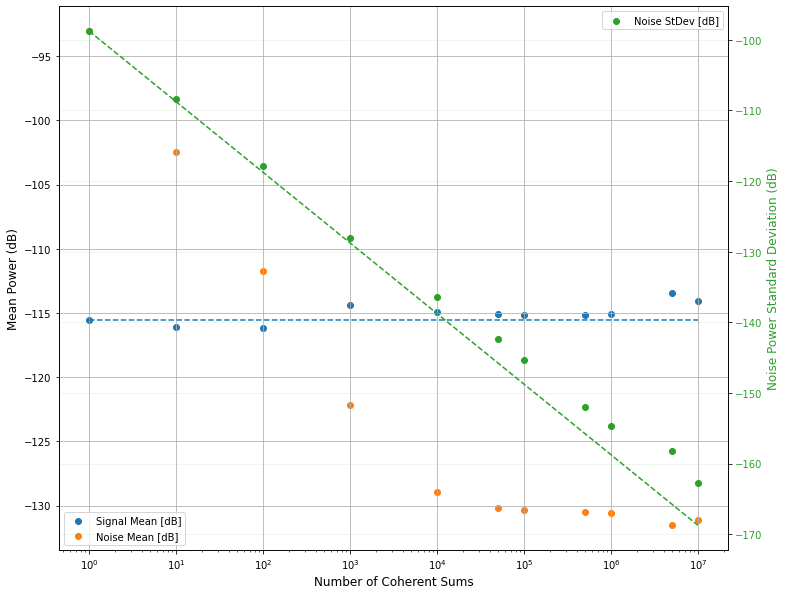

In [14]:
fig, ax1 = plt.subplots(figsize=(12,10), facecolor='white')
ax1.set_xscale('log')
ax2 = ax1.twinx()
ax1.scatter(plot_data_stack['n_stack'], 20*np.log10(plot_data_stack['signal_mean']), label="Signal Mean [dB]", c='tab:blue')
ax1.scatter(plot_data_stack['n_stack'], 20*np.log10(plot_data_stack['noise_mean']), label="Noise Mean [dB]", c='tab:orange')

ax2.scatter(plot_data_stack['n_stack'], 20*np.log10(plot_data_stack['noise_std']), label="Noise StDev [dB]", c='tab:green')

ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
ax1.grid()
#ax1.set_aspect('equal')
#ax1.set_ylim(-140,-10)
#ax2.set_ylim(-140,-80)

print(len(plot_data_stack['signal_mean']))

# Add expected coherent stacking lines
sig_mean_n1 = 20*np.log10(plot_data_stack['signal_mean'][0])
ax1.plot(plot_data_stack['n_stack'], sig_mean_n1*np.ones_like(plot_data_stack['n_stack']), c='tab:blue', linestyle="--")
noise_std_n1 = 20*np.log10(plot_data_stack['noise_std'][0])
ax2.plot(plot_data_stack['n_stack'], -10 * np.log10(np.array(plot_data_stack['n_stack'])) + noise_std_n1, c='tab:green', linestyle="--") # TODO

color = 'tab:green'
ax2.set_ylabel('Noise Power Standard Deviation (dB)', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(color=color, alpha=0.1)
ax1.set_xlabel('Number of Coherent Sums', fontsize=12)
ax1.set_ylabel('Mean Power (dB)', fontsize=12)

fig.savefig("plots/" + prefix[11:] + "_snr_stacks.png", dpi=300)

In [ ]:
print(20*np.log10(plot_data_stack['noise_std'][0]))
fig, ax1 = plt.subplots(figsize=(12,10), facecolor='white')
ax1.set_xscale('log')
ax1.scatter(plot_data_stack['n_stack'], 20*np.log10(plot_data_stack['noise_std']), label="Noise StDev [dB]", c='tab:green')
#ax1.plot(plot_data_stack['n_stack'], -10 * np.log10(np.array(plot_data_stack['n_stack'])) + noise_std_n1, c='tab:green', linestyle="--") # TODO


In [ ]:
print(np.argmax(np.abs(pulse_compressed)))
print(dist_to_reflector[1] - dist_to_reflector[0])

In [ ]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
ax.plot(ret_power[:,0])
ax.set_xlim(45, 50)

In [11]:
prefix[11:]

'20230706_122351'

## Old testing stuff

In [ ]:
prefix = "../../../drone/radar_data/20230511-bench-loopbacksums/20230511_123724" # 90 dB att, 40 MHz BW
#prefix = "../../../drone/radar_data/20230516-bench-sidelobes/20230516_104415" # 100,000 pulses, 30 dB att, 10 us pulse, 30 us recording
#prefix = "../../../drone/radar_data/20230516-bench-sidelobes/20230516_113631" # 100,000 pulses, 45 dB att, 10 us pulse, 30 us recording
#prefix = "../../../drone/radar_data/20230516-bench-sidelobes/20230516_121650" # (60 dB meas #1)

slow_time, fs, radar_data = load_radar_data(prefix, error_behavior='remove')
_, chirp = generate_chirp(load_config(prefix, modifications={'GENERATE': {'window':'blackman'}}))
# fast_time, pulse_compressed = pulse_compress(radar_data, chirp, fs, zero_sample_idx=zero_sample_idx)

In [ ]:
for chirp_idx in range(np.shape(radar_data)[1]):
    radar_data[200:200+len(chirp), chirp_idx] += 0.9*chirp

In [ ]:
(np.sum(np.real(radar_data) >= 1.0)) / np.prod(radar_data.shape)

In [ ]:
np.prod(radar_data.shape)

In [ ]:
n_stack = 1
fast_time, pulse_compressed = pulse_compress(stack(radar_data[:,:n_stack], n_stack), chirp, fs, zero_sample_idx=zero_sample_idx)

dist_to_reflector = fast_time * sig_speed/2

ret_power = 20*np.log10(np.abs(pulse_compressed[:,0]))

fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
ax.plot(dist_to_reflector, ret_power)
ax.grid()
ax.set_xlabel("Distance to reflection")
ax.set_ylabel("Return power [dB]")
ax.text(0, 1.05, prefix.split("/")[-1] + "\n" + f"n_stack = {n_stack}", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# Signal
expected_peak_idx = np.argmin(np.abs(dist_to_reflector - reflector_distance_expected))
search_start_idx = expected_peak_idx - 2
signal_peak_idx = np.argmax(ret_power[search_start_idx:search_start_idx+5]) + search_start_idx

ax.scatter([dist_to_reflector[signal_peak_idx]], [ret_power[signal_peak_idx]], c='red', label="Detected signal peak")

# Noise
noise_start_idx = np.argmin(np.abs(dist_to_reflector - noise_start_m))
noise_end_idx = np.argmin(np.abs(dist_to_reflector - noise_end_m))
noise_region = np.abs(pulse_compressed[noise_start_idx:noise_end_idx:,0])
noise_mean, noise_std = np.mean(noise_region), np.std(noise_region)
noise_mean_db = 20*np.log10(noise_mean)
noise_mean_m1std = 20*np.log10(noise_mean - noise_std)
noise_mean_p1std = 20*np.log10(noise_mean + noise_std)

ax.fill_between(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_m1std * np.ones_like(noise_region), noise_mean_p1std * np.ones_like(noise_region),
               alpha=0.2, color='green')
ax.plot(dist_to_reflector[noise_start_idx:noise_end_idx], noise_mean_db * np.ones_like(noise_region), c='green', linestyle="--")

ax.set_ylim(-100, 10)

np.abs(pulse_compressed[signal_peak_idx,0]), noise_mean, noise_std